# Vision Transformers and EfficientNetV2 for Skin Cancer Diagnosis

---



<h3>Dataset Feature Descriptions</h3>
<p>This dataset contains skin cancer images used for medical research, with the following features:</p>
<ul>
    <li><strong>lesion_id:</strong> A unique identifier for each lesion depicted in the images. Multiple images may correspond to a single lesion if different shots or techniques were used.</li>
    <li><strong>image_id:</strong> A unique identifier for each image, differentiating each image even if they are of the same lesion.</li>
    <li><strong>dx:</strong> The diagnosis code for the lesion, indicating the type of skin lesion diagnosed by medical professionals (e.g., melanoma, nevus).</li>
    <li><strong>dx_type:</strong> The type of diagnosis method used, which could include histopathology, follow-up examination, expert consensus, or other imaging confirmations.</li>
    <li><strong>age:</strong> The age of the patient when the image was taken, important for understanding age-related prevalence of certain skin lesions.</li>
    <li><strong>sex:</strong> The gender of the patient, relevant since some skin cancers are more prevalent in specific genders.</li>
    <li><strong>localization:</strong> The body location of the skin lesion, significant due to varying exposure levels to elements like sunlight.</li>
    <li><strong>dataset:</strong> Indicates the source dataset from which the image was taken, relevant for data collection methodology and understanding dataset biases.</li>
    <li><strong>lesion_type*:</strong> Provides a description of the lesion type, offering more detail than the dx code, such as melanocytic, non-melanocytic, benign, malignant, etc.</li>
    <li><strong>image_path*:</strong> The path to the denoised image file, processed to reduce noise and potentially enhance diagnostic clarity.</li>
    <li><strong>image_path_original*:</strong> The path to the original, unprocessed image file, useful for comparison or studies requiring raw data.</li>
    <li><strong>label*:</strong> An encoded version of the dx diagnosis, transformed into a numerical format suitable for processing by algorithms.</li>
    <li><strong>image*:</strong> A numpy array representing the image loaded from the image_path, used for processing by machine learning models, typically formatted for neural network input.</li>
</ul>
<p> <b>*</b> - indicates additional features created after feature engineering.</p>
<p>For more information, visit the official dataset page on Harvard's Dataverse: <a href="https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T" target="_blank">Skin Cancer Image Dataset</a>.</p>


# Requirements Gathering and Data Collection

##### Mounting drive on Google Co-lab and Extracting .zip file

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/dataverse_files.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [58]:
#Importing necessary libraries

import tensorflow as tf
from keras import models
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Flatten, Dense
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image
import seaborn as sns
import cv2
import plotly.express as px

### Overview of Skin Cancer lesion image samples and meta-data

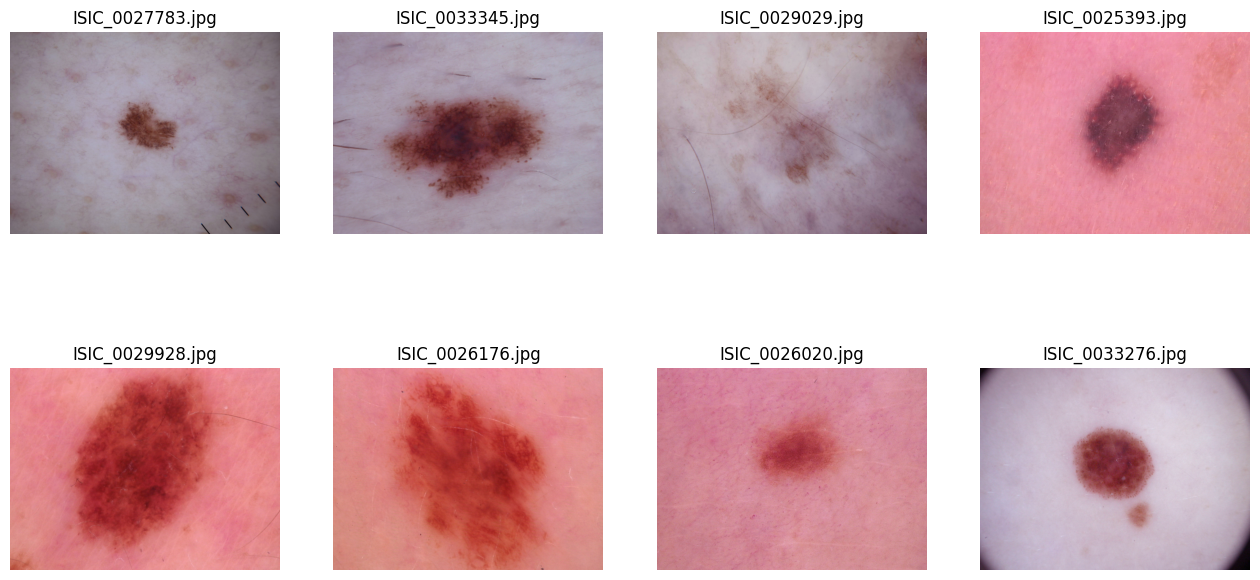

In [35]:
def display_images_from_directory(directory, num_images=8):
    files = os.listdir(directory)

    image_files = [file for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

    num_rows = 2
    num_cols = num_images // num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 8))

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                image_file = image_files[index]
                image_path = os.path.join(directory, image_file)
                img = image.imread(image_path)
                axes[i, j].imshow(img)
                axes[i, j].axis('off')
                axes[i, j].set_title(image_file)

    plt.show()

display_images_from_directory('/content/dataverse_files/HAM10000_images', num_images=8)

In [36]:
data = pd.read_csv("/content/dataverse_files/HAM10000_metadata")
data.sample(10)

lesion_id      image_id   dx    dx_type   age     sex  \
3932  HAM_0000477  ISIC_0026292   nv  follow_up  45.0  female   
508   HAM_0003766  ISIC_0027760  bkl      histo  80.0    male   
8963  HAM_0000762  ISIC_0027137   nv      histo  30.0  female   
5916  HAM_0004541  ISIC_0028838   nv  follow_up  65.0    male   
2298  HAM_0004746  ISIC_0028764  mel      histo  65.0  female   
1657  HAM_0001465  ISIC_0033209  mel      histo  65.0    male   
8627  HAM_0003311  ISIC_0026452   nv      histo  55.0  female   
1903  HAM_0005124  ISIC_0030150  mel      histo  80.0  female   
6991  HAM_0001767  ISIC_0025812   nv      histo  50.0  female   
2224  HAM_0005692  ISIC_0031931  mel      histo  70.0  female   

         localization        dataset  
3932            trunk  vidir_molemax  
508              face      rosendahl  
8963             back      rosendahl  
5916            trunk  vidir_molemax  
2298             back      rosendahl  
1657              ear   vidir_modern  
8627             back      rosendahl  
1903             neck      rosendahl  
6991  lower extremity   vidir_modern  
2224             face      rosendahl

# Data Cleaning and Processing

In [37]:
# Summary of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   dataset       10015 non-null  object 
dtypes: float64(1), object(7)
memory usage: 626.1+ KB


In [38]:
# Descriptive Statistics for numerical variable - Age
data.describe().T

count       mean        std  min   25%   50%   75%   max
age  9958.0  51.863828  16.968614  0.0  40.0  50.0  65.0  85.0

In [39]:
#Finding missing values in dataframe
print("Number of Missing values for each column:\n{}".format(data.isnull().sum()))

Number of Missing values for each column:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
dtype: int64


In [40]:
#Creating two data frames containing replaced and removed missing value instances
data_rem = data.dropna().reset_index(drop=True)
data_rep = data
data_rep.fillna(data_rem.age.median(), inplace=True)

In [41]:
#Converting age variable to integer for the fact that it has no specific decimal numbers other than 0
#Replacing NAN with median values after finding the age varible is right skewed
data_rem.age = data_rem.age.astype('int')
data_rep.age = data_rep.age.astype('int')

In [42]:
#mean and median values for these data frames
print("Mean of age variable in data with removed instances: {}".format(data_rem.age.mean()))
print("Median of age variable in data with removed instances: {}\n".format(data_rem.age.median()))
print("Mean of age variable in data with replaced NAN instances: {}".format(data_rep.age.mean()))
print("Median of age variable in data with replaced NAN instances: {}\n".format(data_rep.age.median()))

data_rep.describe().T

Mean of age variable in data with removed instances: 51.863828077927295
Median of age variable in data with removed instances: 50.0

Mean of age variable in data with replaced NAN instances: 51.853220169745384
Median of age variable in data with replaced NAN instances: 50.0



count      mean        std  min   25%   50%   75%   max
age  10015.0  51.85322  16.920833  0.0  40.0  50.0  65.0  85.0

# Exploratory Data Analysis (EDA)

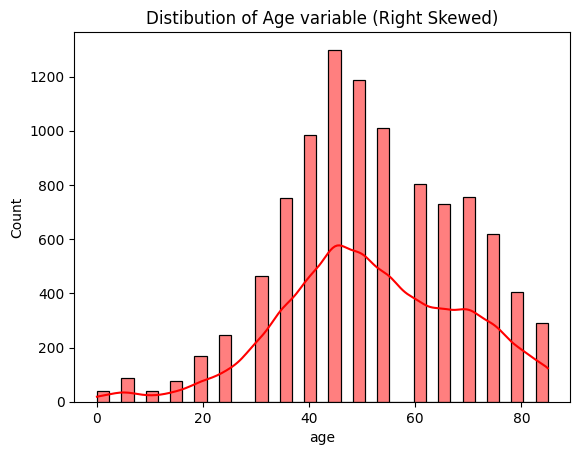

In [43]:
#plotting a Histogram for Age variable

sns.histplot(data_rem.age, color='red', kde=True)
plt.title("Distibution of Age variable (Right Skewed)")
plt.show()

In [44]:
#Interactive Pie Chart for Diagnosis
category_counts = data_rep['dx'].value_counts().reset_index()
category_counts.columns = ['dx', 'count']

custom_colors = px.colors.qualitative.Set1
category_counts['percentage'] = category_counts['count'] / category_counts['count'].sum() * 100

fig = px.pie(category_counts, values='count', names='dx', title='Distribution of Diagnosis(dx)',
             hover_data=['percentage'], labels={'percentage': 'Percentage'}, color_discrete_sequence=custom_colors)
fig.update_traces(textinfo='percent+label')

fig.show()

<ipython-input-45-379a534fc7ee>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




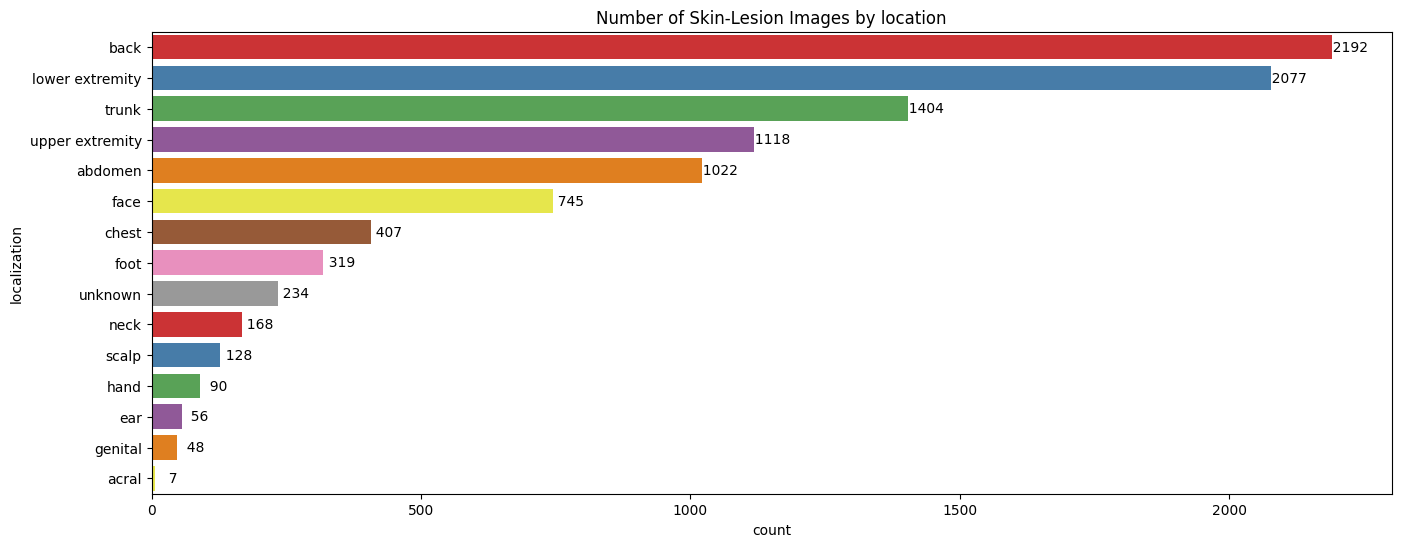

In [45]:
# Plotting Count Plot for images by location
fig, axs = plt.subplots(1, 1, figsize=(16, 6))

sorted_location = data_rep.localization.value_counts().index
sns.countplot(y='localization', data=data_rep, order=sorted_location, palette='Set1')
axs.set_title('Number of Skin-Lesion Images by location')

for p in axs.patches:
    axs.annotate(f'  {int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.),
                    ha='center', va='center', xytext=(10, 0), textcoords='offset points', rotation=0)
plt.show()

<ipython-input-46-d4a70c04ed90>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




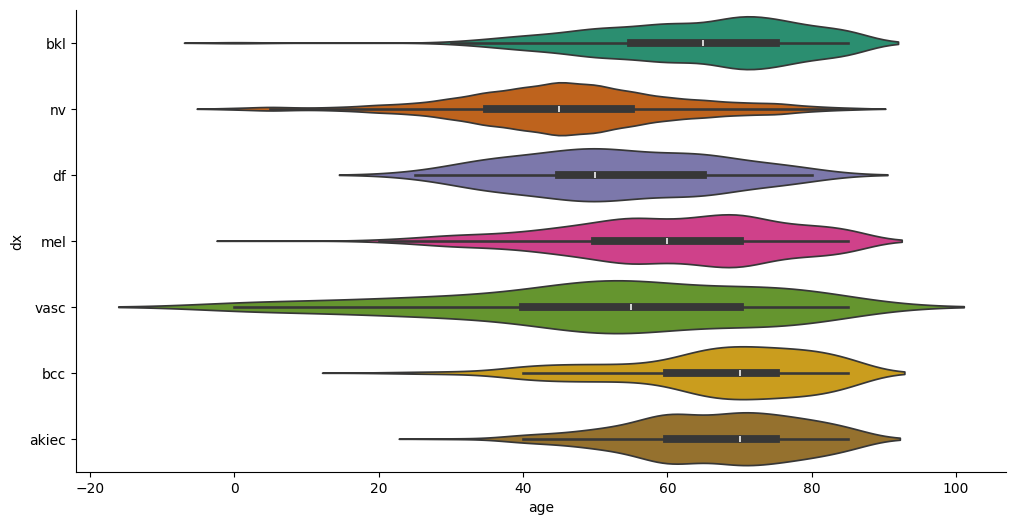

In [46]:
# Plotting Violin plot to observe the distribution of age over diagnosis

plt.figure(figsize=(12, 6))
sns.violinplot(data_rep, x='age', y='dx', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=False, left=False)
plt.show()

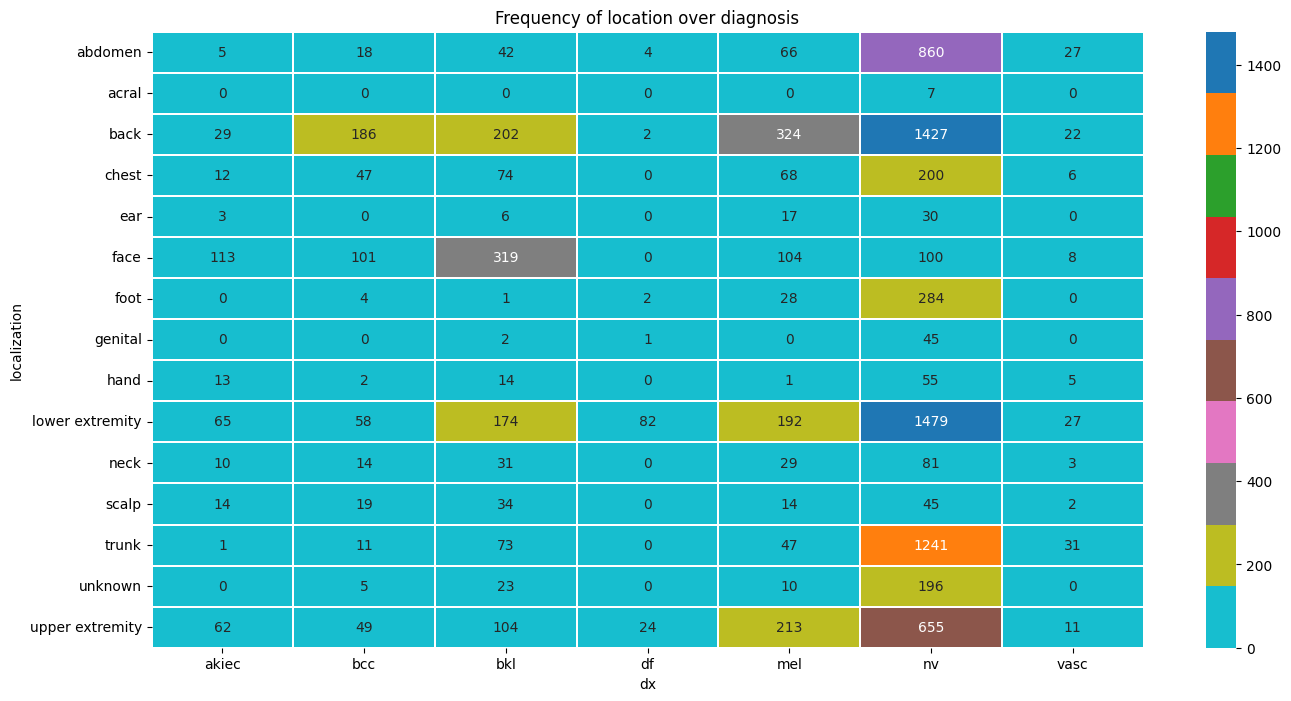

In [47]:
#Number of Skin-Lesion Images that relate to location and pigmented lesion
plt.figure(figsize=(16,8))
crstb = pd.crosstab(data_rep.localization, data_rep.dx)

sns.heatmap(crstb, linewidths=0.003, cmap='tab10_r', annot=True, fmt='d')
plt.title('Frequency of location over diagnosis')
plt.show()

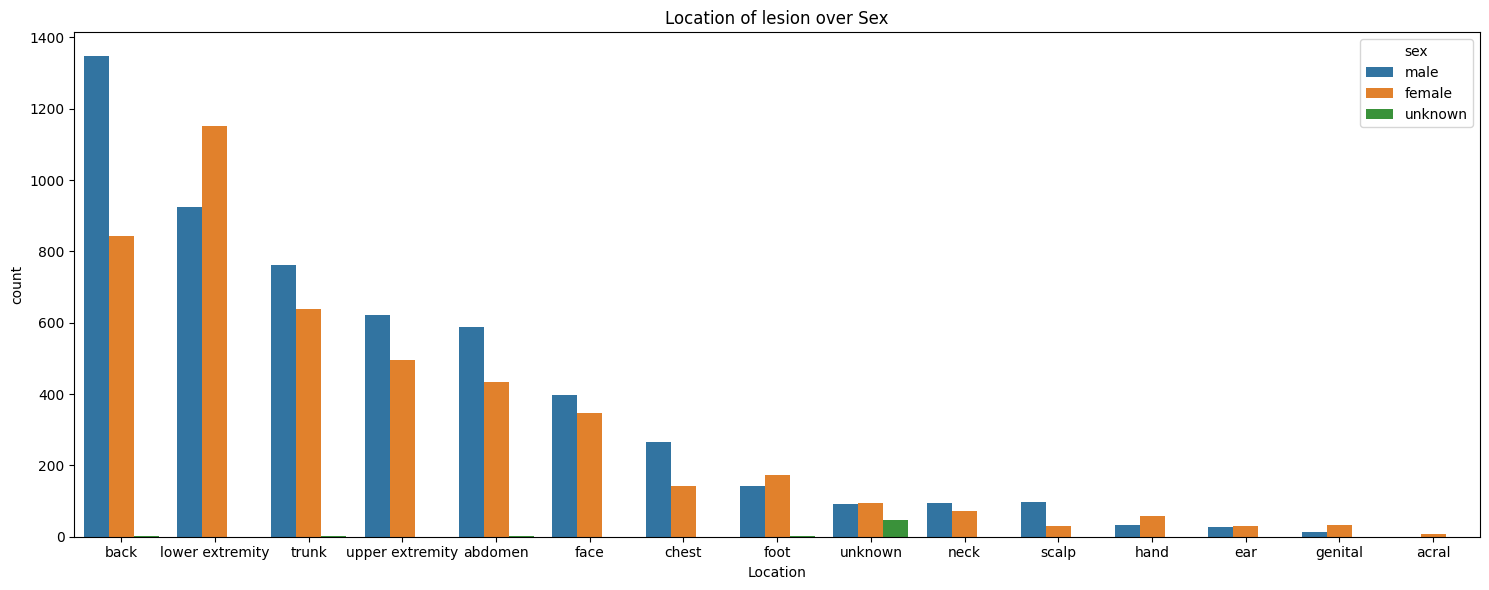

In [48]:
# Plotting barplot for Location of image over sex

plt.figure(figsize=(15,6))
sns.countplot(x='localization', hue='sex', data=data_rep, order=sorted_location)
plt.xlabel('Location')
plt.title('Location of lesion over Sex')
plt.tight_layout()
plt.show()

## Feature Engineering and Image Preprocessing

In [49]:
# Creating a feature with full name for diagnosis(dx) using map function

lesion_type = {
    'akiec': 'Actinic keratoses and intraepithelial carcinoma (akiec)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'df': 'Dermatofibroma (df)',
    'mel': 'Melanoma (mel)',
    'nv': 'Melanocytic nevi (nv)',
    'vasc': 'Vascular lesions (vasc)',
}

dx_map = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}

skin_data = data_rep
skin_data['lesion_type'] = skin_data['dx'].map(lesion_type.get)

In [50]:
# Retrieving image paths using image id

def get_image_paths(directory):
    files = os.listdir(directory)
    image_files = [file for file in files if file.lower().endswith(('.jpg'))]


    image_paths = {}

    for image_file in image_files:
        image_name = os.path.splitext(image_file)[0]
        image_path = os.path.join(directory, image_file)
        image_paths[image_name] = image_path

    return image_paths
image_paths = get_image_paths('/content/dataverse_files/HAM10000_images')
skin_data['image_path'] = skin_data['image_id'].map(image_paths.get)

skin_data.head()

lesion_id      image_id   dx dx_type  age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo   80  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo   80  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo   80  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo   80  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo   75  male          ear   

        dataset                          lesion_type  \
0  vidir_modern  Benign keratosis-like lesions (bkl)   
1  vidir_modern  Benign keratosis-like lesions (bkl)   
2  vidir_modern  Benign keratosis-like lesions (bkl)   
3  vidir_modern  Benign keratosis-like lesions (bkl)   
4  vidir_modern  Benign keratosis-like lesions (bkl)   

                                          image_path  
0  /content/dataverse_files/HAM10000_images/ISIC_...  
1  /content/dataverse_files/HAM10000_images/ISIC_...  
2  /content/dataverse_files/HAM10000_images/ISIC_...  
3  /content/dataverse_files/HAM10000_images/ISIC_...  
4  /content/dataverse_files/HAM10000_images/ISIC_...

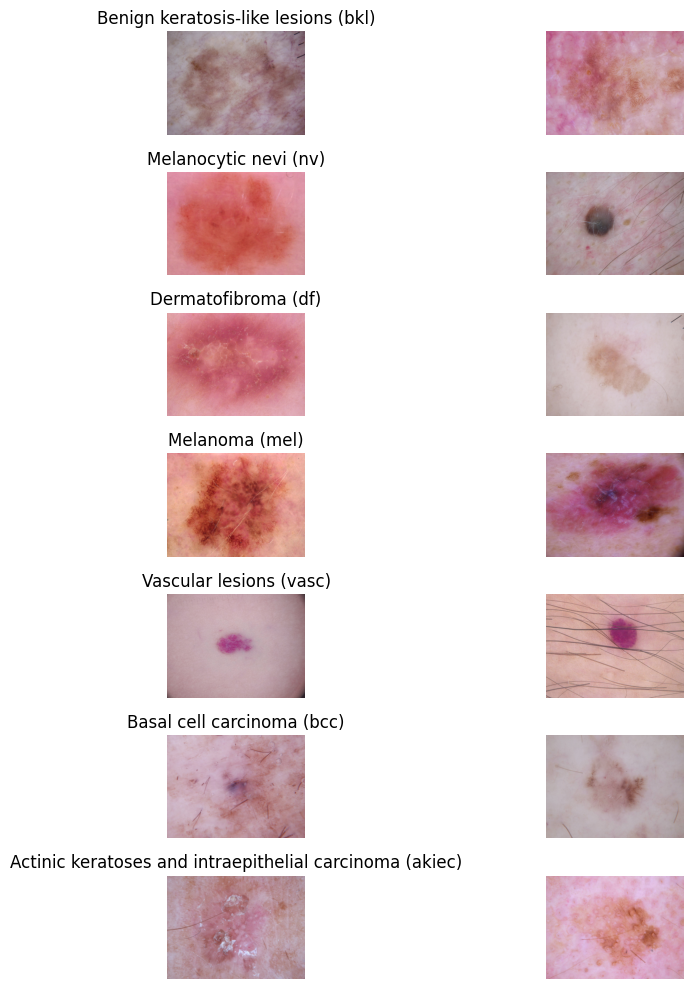

In [51]:
# Displaying Original Skin Cancer Images (Sample=2)

def display_images_two_per_class(dataframe, class_names):
    selected_images = {}

    for class_name in class_names:
        class_images = dataframe[dataframe['lesion_type'] == class_name].sample(n=2, random_state=25)
        selected_images[class_name] = class_images['image_path'].tolist()

    num_rows = 7
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

    for i, class_name in enumerate(class_names):
        for j in range(2):
            image_path = selected_images[class_name][j]
            img = image.imread(image_path)

            if j == 0:
                axes[i, j].set_title(f"{class_name}")

            axes[i, j].imshow(img)
            axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()
display_images_two_per_class(skin_data, ['Benign keratosis-like lesions (bkl)', 'Melanocytic nevi (nv)',
                                       'Dermatofibroma (df)', 'Melanoma (mel)', 'Vascular lesions (vasc)',
                                       'Basal cell carcinoma (bcc)',
                                       'Actinic keratoses and intraepithelial carcinoma (akiec)'])


### Image Denoising using Digital Hair Removal Algorithm

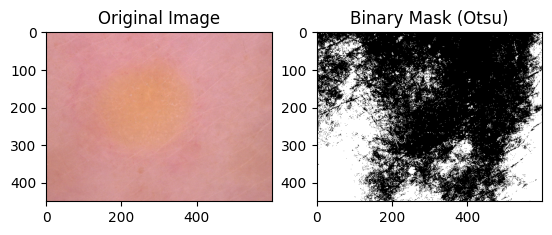

In [52]:
# Experimenting Region Of Interest(ROI) on Skin Cancer Images
image = cv2.imread('/content/dataverse_files/HAM10000_images/ISIC_0024337.jpg')

#Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#OTSU thresholding
_, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

reversed_mask = cv2.bitwise_not(binary_mask)

plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(reversed_mask, cmap='gray'), plt.title('Binary Mask (Otsu)')
plt.show()




> **Insight:** Indication that Region of Interest might not be the best Image Preprocessing technique for these skin cancer images.













 > **Note:** If you don't have a denoised images directory in your local or working directory, execute after removing the multi-line comments from the following two code cells.






### **Digital Hair Removal Algorithm**

In [ ]:
'''
def remove_hairs(image_path):
    original_image = cv2.imread(image_path)
    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(1, (17, 17))
    blackhat = cv2.morphologyEx(grayscale_image, cv2.MORPH_BLACKHAT, kernel)

    _, thresholded = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    inpainted_image = cv2.inpaint(original_image, thresholded, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    return original_image, inpainted_image

image_dir = "/content/dataverse_files/HAM10000_images/"
denoised_image_dir = "/content/dataverse_files/Denoised_HAM10000_images"
os.makedirs(denoised_image_dir, exist_ok=True)

denoised_image_paths = []

for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_dir, filename)
        original_image, denoised_image = remove_hairs(image_path)

        denoised_image_path = os.path.join(denoised_image_dir, filename)
        cv2.imwrite(denoised_image_path, denoised_image)

        denoised_image_paths.append((original_image, denoised_image))

'''

'\ndef remove_hairs(image_path):\n    original_image = cv2.imread(image_path)\n    grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)\n    kernel = cv2.getStructuringElement(1, (17, 17))\n    blackhat = cv2.morphologyEx(grayscale_image, cv2.MORPH_BLACKHAT, kernel)\n\n    _, thresholded = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)\n    inpainted_image = cv2.inpaint(original_image, thresholded, inpaintRadius=5, flags=cv2.INPAINT_TELEA)\n\n    return original_image, inpainted_image\n\nimage_dir = "/content/dataverse_files/HAM10000_images/"\ndenoised_image_dir = "/content/dataverse_files/Denoised_HAM10000_images"\nos.makedirs(denoised_image_dir, exist_ok=True)\n\ndenoised_image_paths = []\n\nfor filename in os.listdir(image_dir):\n    if filename.endswith(".jpg"):\n        image_path = os.path.join(image_dir, filename)\n        original_image, denoised_image = remove_hairs(image_path)\n\n        denoised_image_path = os.path.join(denoised_image_dir, filename)\n    

In [ ]:
'''
num_images_to_display = min(5, len(denoised_image_paths))
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(10, 4*num_images_to_display))
fig.suptitle('Original vs Denoised Images')

for i, (original_image, denoised_image) in enumerate(denoised_image_paths[:num_images_to_display]):
    axes[i, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title('Denoised')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()
'''

"\nnum_images_to_display = min(5, len(denoised_image_paths))\nfig, axes = plt.subplots(num_images_to_display, 2, figsize=(10, 4*num_images_to_display))\nfig.suptitle('Original vs Denoised Images')\n\nfor i, (original_image, denoised_image) in enumerate(denoised_image_paths[:num_images_to_display]):\n    axes[i, 0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))\n    axes[i, 0].set_title('Original')\n    axes[i, 0].axis('off')\n\n    axes[i, 1].imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))\n    axes[i, 1].set_title('Denoised')\n    axes[i, 1].axis('off')\n\nplt.tight_layout()\nplt.show()\n"

#### **Displaying the Comparision between Original and Denoised Images after applying Digital Hair Removal Algorithm**



In [53]:
image_paths_original = get_image_paths('/content/dataverse_files/HAM10000_images')
skin_data['image_path_original'] = skin_data['image_id'].map(image_paths.get)

In [54]:
def get_image_path(image_id, directory):
    image_filename = str(image_id) + '.jpg'
    image_path = os.path.join(directory, image_filename)
    if os.path.exists(image_path):
        return image_path
    else:
        return None

image_df = skin_data
directory = '/content/dataverse_files/Denoised_HAM10000_images'
id_column = 'image_id'
path_column = 'image_path'

for index, row in image_df.iterrows():
    image_id = row[id_column]
    image_path = get_image_path(image_id, directory)
    image_df.at[index, path_column] = image_path

image_df.head(2)

lesion_id      image_id   dx dx_type  age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo   80  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo   80  male        scalp   

        dataset                          lesion_type  \
0  vidir_modern  Benign keratosis-like lesions (bkl)   
1  vidir_modern  Benign keratosis-like lesions (bkl)   

                                          image_path  \
0  /content/dataverse_files/Denoised_HAM10000_ima...   
1  /content/dataverse_files/Denoised_HAM10000_ima...   

                                 image_path_original  
0  /content/dataverse_files/HAM10000_images/ISIC_...  
1  /content/dataverse_files/HAM10000_images/ISIC_...

In [56]:
skin_data.image_id[3803]

'ISIC_0026812'

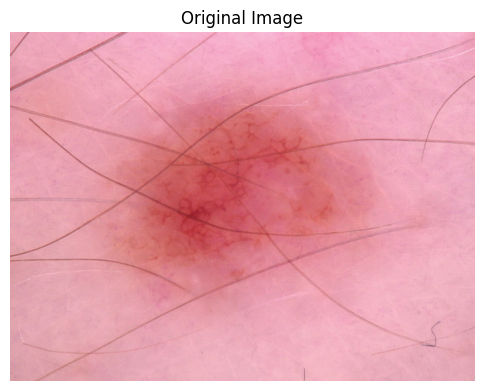

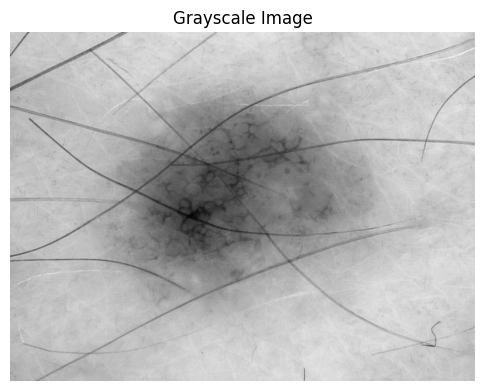

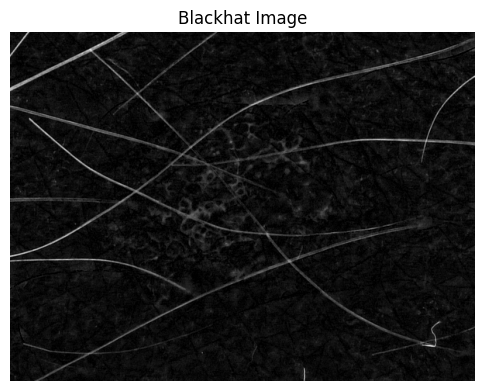

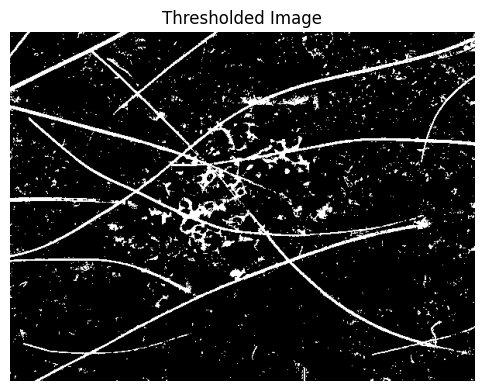

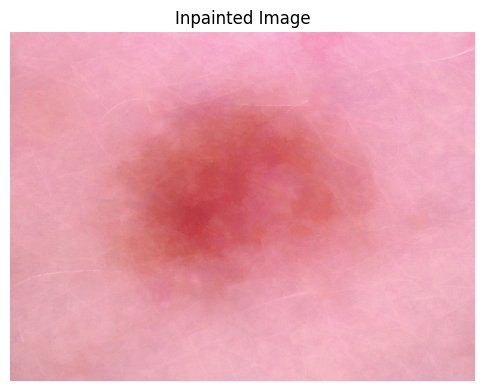

In [60]:
import cv2
import matplotlib.pyplot as plt

def display_image(img, title="Image", cmap=None):
    """ Utility function to display an image. """
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image
image_path = skin_data.image_path_original[3803]
original_image = cv2.imread(image_path)
display_image(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB), "Original Image")

# Convert to grayscale
grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
display_image(grayscale_image, "Grayscale Image", cmap='gray')

# Create a morphological kernel
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))

# Apply black hat morphological operation
blackhat = cv2.morphologyEx(grayscale_image, cv2.MORPH_BLACKHAT, kernel)
display_image(blackhat, "Blackhat Image", cmap='gray')

# Apply threshold
_, thresholded = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
display_image(thresholded, "Thresholded Image", cmap='gray')

# Perform inpainting
inpainted_image = cv2.inpaint(original_image, thresholded, inpaintRadius=5, flags=cv2.INPAINT_TELEA)
display_image(cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2RGB), "Inpainted Image")



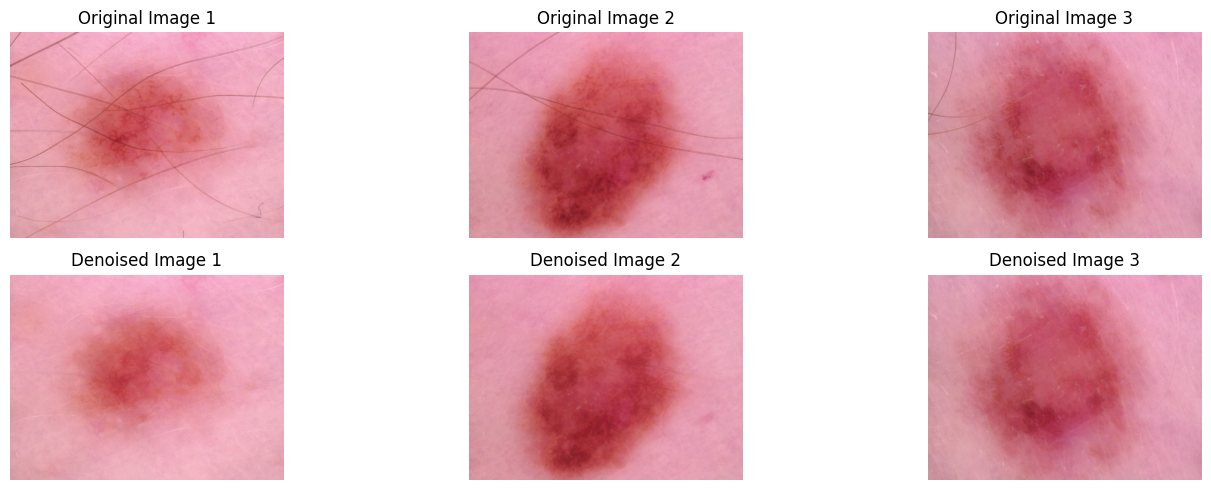

In [ ]:
# Displaying the Comparision between Original and Denoised Images after applying Digital Noise Removal Algorithm.

original_image_paths = skin_data.image_path_original[3803:3806]
denoised_image_paths = skin_data.image_path[3803:3806]

plt.figure(figsize=(15, 5))

for i, (original_path, denoised_path) in enumerate(zip(original_image_paths, denoised_image_paths), start=1):
    original_image = cv2.imread(original_path)
    denoised_image = cv2.imread(denoised_path)

    plt.subplot(2, 3, i)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Original Image {i}')
    plt.axis('off')

    plt.subplot(2, 3, i+3)
    plt.imshow(cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Denoised Image {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Preparing Data for Model Training, Testing and Validation

In [ ]:
image_df['label'] = LabelEncoder().fit_transform(image_df['dx'])

print("Label Encoding:")
for original_label, encoded_label in zip(image_df['dx'].unique(), image_df['label'].unique()):
    print(f"{original_label} -> {encoded_label}")

image_df['image'] = image_df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))
image_df.head(2)

Label Encoding:
bkl -> 2
nv -> 5
df -> 3
mel -> 4
vasc -> 6
bcc -> 1
akiec -> 0


lesion_id      image_id   dx dx_type  age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo   80  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo   80  male        scalp   

        dataset                          lesion_type  \
0  vidir_modern  Benign keratosis-like lesions (bkl)   
1  vidir_modern  Benign keratosis-like lesions (bkl)   

                                          image_path  \
0  /content/dataverse_files/Denoised_HAM10000_ima...   
1  /content/dataverse_files/Denoised_HAM10000_ima...   

                                 image_path_original  label  \
0  /content/dataverse_files/HAM10000_images/ISIC_...      2   
1  /content/dataverse_files/HAM10000_images/ISIC_...      2   

                                               image  
0  [[[191, 152, 192], [194, 154, 193], [196, 153,...  
1  [[[25, 14, 28], [56, 39, 64], [106, 80, 112], ...

In [ ]:
image_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'dataset', 'lesion_type', 'image_path', 'image_path_original', 'label',
       'image'],
      dtype='object')

In [ ]:
grouped_indices = image_df.groupby('label').apply(lambda x: x.index.values).to_dict()

augmented_data_frames = []

for label, indices in grouped_indices.items():
    df = image_df.iloc[indices]
    if label == 0:
        df = df._append([df] * 19, ignore_index=True)
    elif label == 1:
        df = df._append([df] * 12, ignore_index=True)
    elif label == 2:
        df = df._append([df] * 5, ignore_index=True)
    elif label == 3:
        df = df._append([df] * 57, ignore_index=True)
    elif label == 4:
        df = df._append([df] * 5, ignore_index=True)
    elif label == 6:
        df = df._append([df] * 46, ignore_index=True)

    augmented_data_frames.append(df)

augmented_data = pd.concat(augmented_data_frames, ignore_index=True)
print(augmented_data.shape)
augmented_data.label.value_counts()

(46543, 13)


label
5    6705
1    6682
4    6678
6    6674
3    6670
2    6594
0    6540
Name: count, dtype: int64

In [ ]:
# ORIGINAL DATA
X_orig = image_df['image'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
y_orig = np.array(image_df.label)
print(X_orig.shape)
print(y_orig.shape)


# AUGMENTED DATA
X_aug = augmented_data['image'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
y_aug = np.array(augmented_data.label)
print(X_aug.shape)
print(y_aug.shape)

(10015, 32, 32, 3)
(10015,)
(46543, 32, 32, 3)
(46543,)


In [ ]:
# function to plot acccuracy and loss of the model
def plot_accuracy_and_loss(model):

    fig, ax = plt.subplots(nrows=2, ncols=1)

    ax[0].plot(model.history['accuracy'])
    ax[0].plot(model.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train_acc', 'val_acc'], loc='upper left')
    #plt.show()


    ax[1].plot(model.history['loss'])
    ax[1].plot(model.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train_loss', 'val_loss'], loc='upper left')
    fig.tight_layout()
    plt.show()

In [ ]:
# functions to perform random image transformation and preparing data
def create_random_augmentation():
    (rotation_range, width_shift_range, height_shift_range, shear_range,
     zoom_range, brightness_range, channel_shift_range, horizontal_flip,
     vertical_flip, fill_mode) = generate_random_params()

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        brightness_range=brightness_range,
        channel_shift_range=channel_shift_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        fill_mode=fill_mode
    )
    return train_datagen

def generate_random_params():
    rotation_range = np.random.uniform(0, 360)
    width_shift_range = np.random.uniform(0, 0.2)
    height_shift_range = np.random.uniform(0, 0.2)
    shear_range = np.random.uniform(0, 0.2)
    zoom_range = np.random.uniform(0.2, 0.5)
    brightness_range = [0.5, 1.5]
    channel_shift_range = np.random.uniform(0.1, 0.5)
    horizontal_flip = np.random.choice([True, False])
    vertical_flip = np.random.choice([True, False])
    fill_mode = np.random.choice(['nearest', 'constant', 'reflect', 'wrap'])

    return (rotation_range, width_shift_range, height_shift_range, shear_range,
            zoom_range, brightness_range, channel_shift_range, horizontal_flip, vertical_flip, fill_mode)

def prepare_for_train_validation_test(X, y):
    # Splitting the data into train and temp sets first (75-25)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=1)

    # splitting the temp set into validation and test sets (50-50)
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)
    return X_train, X_valid, X_test, y_train, y_valid, y_test



#X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_for_train_validation_test(X_orig, y_orig)
X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_for_train_validation_test(X_aug, y_aug)


train_datagen = create_random_augmentation()
train_datagen.fit(X_train)
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen.fit(X_valid)
test_datagen.fit(X_test)

In [ ]:
# input shape and callbacks parameter
input_shape = (32, 32, 3)
reduce_LearningRate = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.001, )

# Model Training

## EfficientNet and EfficientNetV2

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from tensorflow.keras.applications.efficientnet import EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from tensorflow.keras.applications import EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3
from tensorflow.keras.applications import EfficientNetV2S, EfficientNetV2M, EfficientNetV2L

In [ ]:
 def EfficientNet(model_fn ='b0', epochs=10, input_shape=input_shape):
      if model_fn == 'b0':
          base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'b1':
          base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'b2':
          base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'b3':
          base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'b4':
          base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'b5':
          base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'b6':
          base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'b7':
          base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'v2b0':
          base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'v2b1':
          base_model = EfficientNetV2B1(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'v2b2':
          base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'v2b3':
          base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'v2s':
          base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'v2m':
          base_model = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=input_shape)

      elif model_fn == 'v2l':
          base_model = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=input_shape)


      x = base_model.output
      x = tf.keras.layers.GlobalAveragePooling2D()(x)
      x = tf.keras.layers.Dense(1024, activation='relu')(x)
      output = tf.keras.layers.Dense(7, activation='softmax')(x)

      model = tf.keras.Model(inputs=base_model.input, outputs=output)
      model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

      model_history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), callbacks = [reduce_LearningRate])
      return model_history


### **Session 1:** Model Training on all pre- trained EfficientNet and EfficientNetV2functions with denoised images before agumentation

In [ ]:
#Training all pre-trained EfficinetNet functions with denoised images before image augmentation
'''
Eff_B0 = EfficientNet(model_fn='b0', epochs=10, input_shape = input_shape)

Eff_B1 = EfficientNet(model_fn='b1', epochs=10, input_shape = input_shape)

Eff_B2 = EfficientNet(model_fn='b2', epochs=10, input_shape = input_shape)

Eff_B3 = EfficientNet(model_fn='b3', epochs=10, input_shape = input_shape)

Eff_B4 = EfficientNet(model_fn='b4', epochs=10, input_shape = input_shape)

Eff_B5 = EfficientNet(model_fn='b5', epochs=10, input_shape = input_shape)

Eff_B6 = EfficientNet(model_fn='b6', epochs=10, input_shape = input_shape)

Eff_B7 = EfficientNet(model_fn='b7', epochs=10, input_shape = input_shape)

Eff_V2B0 = EfficientNet(model_fn='v2b0', epochs=10, input_shape = input_shape)

Eff_V2B1 = EfficientNet(model_fn='v2b1', epochs=10, input_shape = input_shape)

Eff_V2B2 = EfficientNet(model_fn='v2b2', epochs=10, input_shape = input_shape)

Eff_V2B3 = EfficientNet(model_fn='v2b3', epochs=10, input_shape = input_shape)

Eff_V2S = EfficientNet(model_fn='v2s', epochs=10, input_shape = input_shape)

Eff_V2M = EfficientNet(model_fn='v2m', epochs=10, input_shape = input_shape)

Eff_V2L = EfficientNet(model_fn='v2l', epochs=10, input_shape = input_shape)

'''

"\nEff_B0 = EfficientNet(model_fn='b0', epochs=10, input_shape = input_shape)\n\nEff_B1 = EfficientNet(model_fn='b1', epochs=10, input_shape = input_shape)\n\nEff_B2 = EfficientNet(model_fn='b2', epochs=10, input_shape = input_shape)\n\nEff_B3 = EfficientNet(model_fn='b3', epochs=10, input_shape = input_shape)\n\nEff_B4 = EfficientNet(model_fn='b4', epochs=10, input_shape = input_shape)\n\nEff_B5 = EfficientNet(model_fn='b5', epochs=10, input_shape = input_shape)\n\nEff_B6 = EfficientNet(model_fn='b6', epochs=10, input_shape = input_shape)\n\nEff_B7 = EfficientNet(model_fn='b7', epochs=10, input_shape = input_shape)\n\nEff_V2B0 = EfficientNet(model_fn='v2b0', epochs=10, input_shape = input_shape)\n\nEff_V2B1 = EfficientNet(model_fn='v2b1', epochs=10, input_shape = input_shape)\n\nEff_V2B2 = EfficientNet(model_fn='v2b2', epochs=10, input_shape = input_shape)\n\nEff_V2B3 = EfficientNet(model_fn='v2b3', epochs=10, input_shape = input_shape)\n\nEff_V2S = EfficientNet(model_fn='v2s', epochs

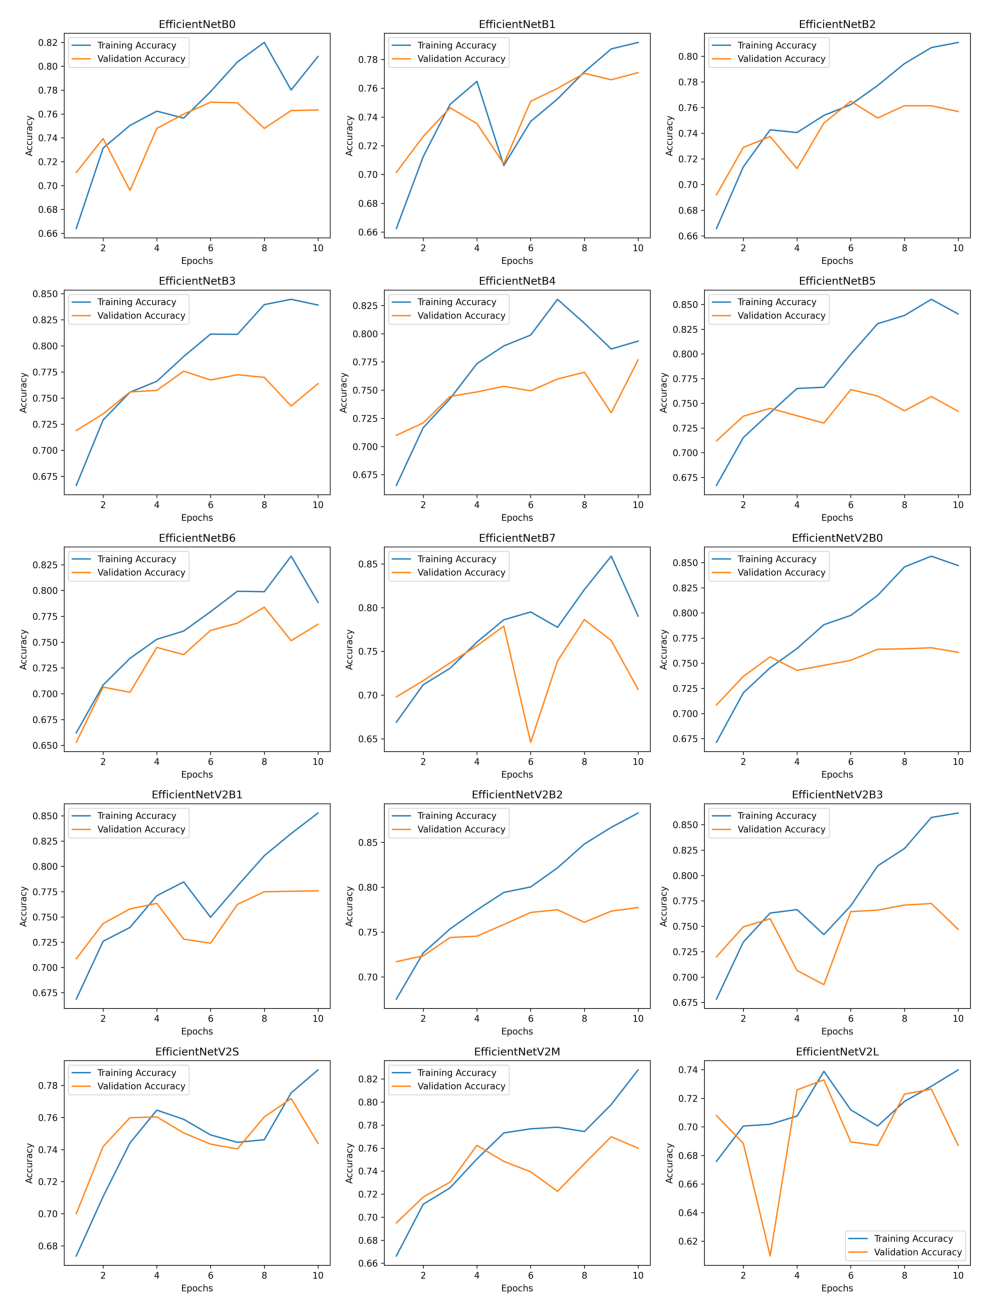

In [ ]:
'''
models = {"EfficientNetB0": {"train_acc": Eff_B0.history['accuracy'], "val_acc": Eff_B0.history['val_accuracy']},
          "EfficientNetB1": {"train_acc": Eff_B1.history['accuracy'], "val_acc": Eff_B1.history['val_accuracy']},
          "EfficientNetB2": {"train_acc": Eff_B2.history['accuracy'], "val_acc": Eff_B2.history['val_accuracy']},
          "EfficientNetB3": {"train_acc": Eff_B3.history['accuracy'], "val_acc": Eff_B3.history['val_accuracy']},
          "EfficientNetB4": {"train_acc": Eff_B4.history['accuracy'], "val_acc": Eff_B4.history['val_accuracy']},
          "EfficientNetB5": {"train_acc": Eff_B5.history['accuracy'], "val_acc": Eff_B5.history['val_accuracy']},
          "EfficientNetB6": {"train_acc": Eff_B6.history['accuracy'], "val_acc": Eff_B6.history['val_accuracy']},
          "EfficientNetB7": {"train_acc": Eff_B7.history['accuracy'], "val_acc": Eff_B7.history['val_accuracy']},
          "EfficientNetV2B0": {"train_acc": Eff_V2B0.history['accuracy'], "val_acc": Eff_V2B0.history['val_accuracy']},
          "EfficientNetV2B1": {"train_acc": Eff_V2B1.history['accuracy'], "val_acc": Eff_V2B1.history['val_accuracy']},
          "EfficientNetV2B2": {"train_acc": Eff_V2B2.history['accuracy'], "val_acc": Eff_V2B2.history['val_accuracy']},
          "EfficientNetV2B3": {"train_acc": Eff_V2B3.history['accuracy'], "val_acc": Eff_V2B3.history['val_accuracy']},
          "EfficientNetV2S": {"train_acc": Eff_V2S.history['accuracy'], "val_acc": Eff_V2S.history['val_accuracy']},
          "EfficientNetV2M": {"train_acc": Eff_V2M.history['accuracy'], "val_acc": Eff_V2M.history['val_accuracy']},
          "EfficientNetV2L": {"train_acc": Eff_V2L.history['accuracy'], "val_acc": Eff_V2L.history['val_accuracy']}}

fig, axs = plt.subplots(5, 3, figsize=(15, 20))
axs = axs.flatten()

for idx, (model_name, accuracies) in enumerate(models.items()):
    epochs = range(1, len(accuracies['train_acc']) + 1)
    axs[idx].plot(epochs, accuracies['train_acc'], label='Training Accuracy')
    axs[idx].plot(epochs, accuracies['val_acc'], label='Validation Accuracy')
    axs[idx].set_title(model_name)
    axs[idx].set_xlabel('Epochs')
    axs[idx].set_ylabel('Accuracy')
    axs[idx].legend()

plt.tight_layout()
plt.savefig('EfficientNet_Accuracies.png', dpi=300)
plt.show()

'''
acc_img = Image.open('/content/dataverse_files/EfficientNet_Accuracies.png')
plt.figure(figsize=(10, 14))
plt.imshow(acc_img)
plt.axis('off')
plt.tight_layout()
plt.show()

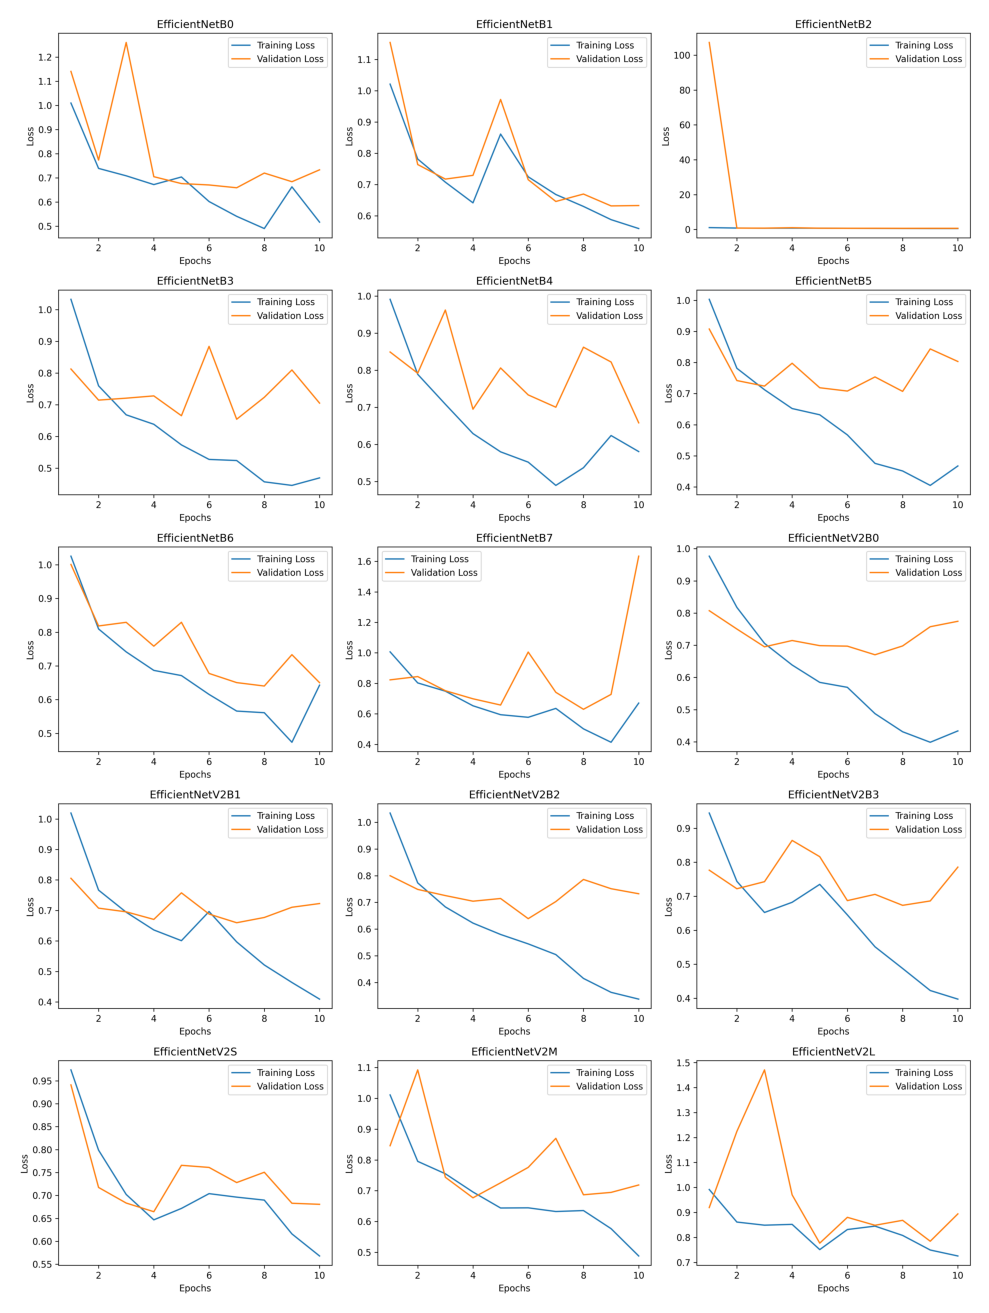

In [ ]:
'''
models_loss = {"EfficientNetB0": {"train_loss": Eff_B0.history['loss'], "val_loss": Eff_B0.history['val_loss']},
          "EfficientNetB1": {"train_loss": Eff_B1.history['loss'], "val_loss": Eff_B1.history['val_loss']},
          "EfficientNetB2": {"train_loss": Eff_B2.history['loss'], "val_loss": Eff_B2.history['val_loss']},
          "EfficientNetB3": {"train_loss": Eff_B3.history['loss'], "val_loss": Eff_B3.history['val_loss']},
          "EfficientNetB4": {"train_loss": Eff_B4.history['loss'], "val_loss": Eff_B4.history['val_loss']},
          "EfficientNetB5": {"train_loss": Eff_B5.history['loss'], "val_loss": Eff_B5.history['val_loss']},
          "EfficientNetB6": {"train_loss": Eff_B6.history['loss'], "val_loss": Eff_B6.history['val_loss']},
          "EfficientNetB7": {"train_loss": Eff_B7.history['loss'], "val_loss": Eff_B7.history['val_loss']},
          "EfficientNetV2B0": {"train_loss": Eff_V2B0.history['loss'], "val_loss": Eff_V2B0.history['val_loss']},
          "EfficientNetV2B1": {"train_loss": Eff_V2B1.history['loss'], "val_loss": Eff_V2B1.history['val_loss']},
          "EfficientNetV2B2": {"train_loss": Eff_V2B2.history['loss'], "val_loss": Eff_V2B2.history['val_loss']},
          "EfficientNetV2B3": {"train_loss": Eff_V2B3.history['loss'], "val_loss": Eff_V2B3.history['val_loss']},
          "EfficientNetV2S": {"train_loss": Eff_V2S.history['loss'], "val_loss": Eff_V2S.history['val_loss']},
          "EfficientNetV2M": {"train_loss": Eff_V2M.history['loss'], "val_loss": Eff_V2M.history['val_loss']},
          "EfficientNetV2L": {"train_loss": Eff_V2L.history['loss'], "val_loss": Eff_V2L.history['val_loss']}}

fig, axs = plt.subplots(5, 3, figsize=(15, 20))
axs = axs.flatten()

for idx, (model_name, losses) in enumerate(models_loss.items()):
    epochs = range(1, len(losses['train_loss']) + 1)
    axs[idx].plot(epochs, losses['train_loss'], label='Training Loss')
    axs[idx].plot(epochs, losses['val_loss'], label='Validation Loss')
    axs[idx].set_title(model_name)
    axs[idx].set_xlabel('Epochs')
    axs[idx].set_ylabel('Loss')
    axs[idx].legend()

plt.tight_layout()
plt.savefig('EfficientNet_Losses.png', dpi=300)
plt.show()

'''
loss_img = Image.open('/content/dataverse_files/EfficientNet_Losses.png')
plt.figure(figsize=(10, 14))
plt.imshow(loss_img)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
'''
accuracy_data = []
for model_name, acc_hist in models.items():
    for epoch_index in range(len(acc_hist['train_acc'])):
        accuracy_data.append({
            "EfficientNet_function": model_name,
            "Epoch": epoch_index + 1,
            "Train Accuracy": acc_hist['train_acc'][epoch_index],
            "Validation Accuracy": acc_hist['val_acc'][epoch_index]
        })

acc_df = pd.DataFrame(accuracy_data)

loss_data = []
for model_name, history in models_loss.items():
    for epoch_index in range(len(history['train_loss'])):
        loss_data.append({
            "EfficientNet_function": model_name,
            "Epoch": epoch_index + 1,
            "Train Loss": history['train_loss'][epoch_index],
            "Validation Loss": history['val_loss'][epoch_index]
        })

loss_df = pd.DataFrame(loss_data)

acc_loss_df = pd.merge(acc_df, loss_df, on=['EfficientNet_function', 'Epoch'])
acc_loss_df.to_csv('EfficientNet_performance_histories.csv', index=False)

final_performances = acc_loss_df[acc_loss_df['Epoch']==10].reset_index(drop=True)
final_performances.to_csv('EfficientNet_performance_after_10_epochs.csv', index=False)

'''
final_performances = pd.read_csv('/content/dataverse_files/EfficientNet_performance_after_10_epochs.csv')
final_performances

EfficientNet_function  Epoch  Train Accuracy  Validation Accuracy  \
0         EfficientNetB0     10        0.808163             0.763355   
1         EfficientNetB1     10        0.791812             0.770844   
2         EfficientNetB2     10        0.810659             0.756865   
3         EfficientNetB3     10        0.839116             0.763854   
4         EfficientNetB4     10        0.793435             0.776835   
5         EfficientNetB5     10        0.840364             0.741887   
6         EfficientNetB6     10        0.788567             0.767349   
7         EfficientNetB7     10        0.790315             0.706440   
8       EfficientNetV2B0     10        0.847104             0.760859   
9       EfficientNetV2B1     10        0.852846             0.775836   
10      EfficientNetV2B2     10        0.882801             0.777334   
11      EfficientNetV2B3     10        0.861458             0.746880   
12       EfficientNetV2S     10        0.789690             0.743884   
13       EfficientNetV2M     10        0.827883             0.759860   
14       EfficientNetV2L     10        0.739890             0.686970   

    Train Loss  Validation Loss  
0     0.516384         0.733005  
1     0.558975         0.632558  
2     0.515879         0.648315  
3     0.469574         0.705207  
4     0.580617         0.658081  
5     0.467484         0.803301  
6     0.642885         0.650340  
7     0.670657         1.633830  
8     0.433819         0.774412  
9     0.409465         0.722714  
10    0.337848         0.732353  
11    0.397447         0.785746  
12    0.567962         0.680617  
13    0.488337         0.718627  
14    0.725770         0.894260

**Insight:** Clearly, EfficientNetV2 function have better performance than EfficientNet. So, I decided to train 3 best EfficientNetV2 models on augmented dataset to choose the best EfficientNetV2 model and to compare with Vision Transformer.



### **Session 2:** Model Training on 3 best EfficientNetV2 (B0, B1 and B2) using augmented dataset



In [ ]:
# Model Training and Validation using augmented data
'''
Eff_V2B0_aug = EfficientNet(model_fn='v2b0', input_shape=input_shape, epochs=10)
Eff_V2B1_aug = EfficientNet(model_fn='v2b1', input_shape=input_shape, epochs=10)
Eff_V2B2_aug = EfficientNet(model_fn='v2b2', input_shape=input_shape, epochs=10)
'''

"\nEff_V2B0_aug = EfficientNet(model_fn='v2b0', input_shape=input_shape, epochs=10)\nEff_V2B1_aug = EfficientNet(model_fn='v2b1', input_shape=input_shape, epochs=10)\nEff_V2B2_aug = EfficientNet(model_fn='v2b2', input_shape=input_shape, epochs=10)\n"

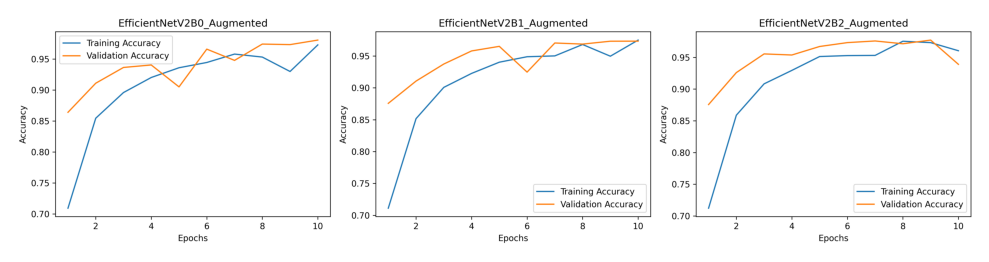

In [ ]:
'''
models = {"EfficientNetV2B0_Augmented": {"train_acc": Eff_V2B0_aug.history['accuracy'], "val_acc": Eff_V2B0_aug.history['val_accuracy']},
          "EfficientNetV2B1_Augmented": {"train_acc": Eff_V2B1_aug.history['accuracy'], "val_acc": Eff_V2B1_aug.history['val_accuracy']},
          "EfficientNetV2B2_Augmented": {"train_acc": Eff_V2B2_aug.history['accuracy'], "val_acc": Eff_V2B2_aug.history['val_accuracy']}}

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs = axs.flatten()

for idx, (model_name, accuracies) in enumerate(models.items()):
    epochs = range(1, len(accuracies['train_acc']) + 1)
    axs[idx].plot(epochs, accuracies['train_acc'], label='Training Accuracy')
    axs[idx].plot(epochs, accuracies['val_acc'], label='Validation Accuracy')
    axs[idx].set_title(model_name)
    axs[idx].set_xlabel('Epochs')
    axs[idx].set_ylabel('Accuracy')
    axs[idx].legend()

plt.tight_layout()
plt.savefig('EfficientNetV2_Aug_Accuracies.png', dpi=300)
plt.show()
'''
acc_aug_img = Image.open('/content/dataverse_files/EfficientNetV2_Aug_Accuracies.png')
plt.figure(figsize=(10, 14))
plt.imshow(acc_aug_img)
plt.axis('off')
plt.tight_layout()
plt.show()

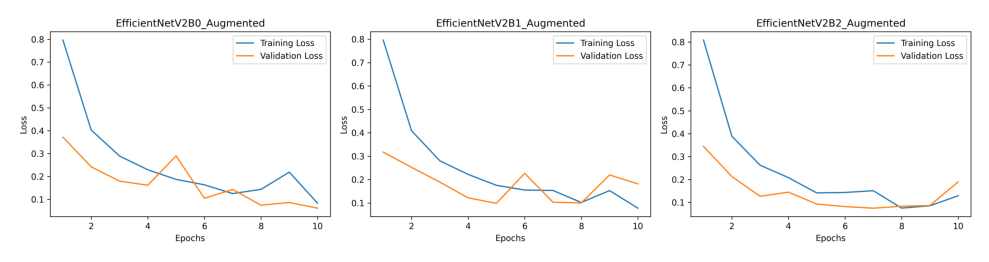

In [ ]:
'''
models_loss = {"EfficientNetV2B0_Augmented": {"train_loss": Eff_V2B0_aug.history['loss'], "val_loss": Eff_V2B0_aug.history['val_loss']},
          "EfficientNetV2B1_Augmented": {"train_loss": Eff_V2B1_aug.history['loss'], "val_loss": Eff_V2B1_aug.history['val_loss']},
          "EfficientNetV2B2_Augmented": {"train_loss": Eff_V2B2_aug.history['loss'], "val_loss": Eff_V2B2_aug.history['val_loss']}}

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs = axs.flatten()

for idx, (model_name, losses) in enumerate(models_loss.items()):
    epochs = range(1, len(losses['train_loss']) + 1)
    axs[idx].plot(epochs, losses['train_loss'], label='Training Loss')
    axs[idx].plot(epochs, losses['val_loss'], label='Validation Loss')
    axs[idx].set_title(model_name)
    axs[idx].set_xlabel('Epochs')
    axs[idx].set_ylabel('Loss')
    axs[idx].legend()

plt.tight_layout()
plt.savefig('EfficientNetV2_Aug_Losses.png', dpi=300)
plt.show()
'''

loss_aug_img = Image.open('/content/dataverse_files/EfficientNetV2_Aug_Losses.png')
plt.figure(figsize=(10, 14))
plt.imshow(loss_aug_img)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
'''
accuracy_data = []
for model_name, acc_hist in models.items():
    for epoch_index in range(len(acc_hist['train_acc'])):
        accuracy_data.append({
            "EfficientNetV2_Aug_function": model_name,
            "Epoch": epoch_index + 1,
            "Train Accuracy": acc_hist['train_acc'][epoch_index],
            "Validation Accuracy": acc_hist['val_acc'][epoch_index]
        })

acc_df = pd.DataFrame(accuracy_data)

loss_data = []
for model_name, history in models_loss.items():
    for epoch_index in range(len(history['train_loss'])):
        loss_data.append({
            "EfficientNetV2_Aug_function": model_name,
            "Epoch": epoch_index + 1,
            "Train Loss": history['train_loss'][epoch_index],
            "Validation Loss": history['val_loss'][epoch_index]
        })

loss_df = pd.DataFrame(loss_data)

acc_loss_df = pd.merge(acc_df, loss_df, on=['EfficientNetV2_Aug_function', 'Epoch'])
#acc_loss_df.to_csv('EfficientNetV2_On_Aug_Data.csv', index=False)

EffV2_Aug_performances = acc_loss_df[acc_loss_df['Epoch']==10].reset_index(drop=True)
EffV2_Aug_performances.to_csv('EffV2_Aug_after_10_epochs.csv', index=False)
'''
final_aug_performances = pd.read_csv('/content/dataverse_files/EffV2_Aug_after_10_epochs.csv')
final_aug_performances

EfficientNetV2_Aug_function  Epoch  Train Accuracy  Validation Accuracy  \
0  EfficientNetV2B0_Augmented     10        0.972901             0.980664   
1  EfficientNetV2B1_Augmented     10        0.974808             0.973144   
2  EfficientNetV2B2_Augmented     10        0.960439             0.938984   

   Train Loss  Validation Loss  
0    0.082840         0.061050  
1    0.077699         0.181720  
2    0.129151         0.189815

### **Session 3:** Model Training and Validation -- final EfficientNetV2 (B2) model and Vision Transformers (ViT8x8 and Swin Tranformer)

In [ ]:
#Final EfficientNetV2 model - EfficientNetV2B2 to undergo model training for 50 epochs
base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=input_shape)
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
output = tf.keras.layers.Dense(7, activation='softmax')(x)
EffV2_model = tf.keras.Model(inputs=base_model.input, outputs=output)

EffV2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
EffV2_model.summary()

35839040/35839040 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 32, 32, 3)            0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          

In [ ]:
EffV2_final_model = EffV2_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32, callbacks = [reduce_LearningRate])

Epoch 1/50
1091/1091 [==============================] - 125s 65ms/step - loss: 0.8097 - accuracy: 0.7128 - val_loss: 0.5204 - val_accuracy: 0.8185 - lr: 0.0010
Epoch 2/50
1091/1091 [==============================] - 68s 62ms/step - loss: 0.4001 - accuracy: 0.8581 - val_loss: 0.2470 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 3/50
1091/1091 [==============================] - 68s 62ms/step - loss: 0.2760 - accuracy: 0.9045 - val_loss: 0.1844 - val_accuracy: 0.9357 - lr: 0.0010
Epoch 4/50
1091/1091 [==============================] - 68s 62ms/step - loss: 0.2679 - accuracy: 0.9071 - val_loss: 0.1143 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 5/50
1091/1091 [==============================] - 69s 63ms/step - loss: 0.1970 - accuracy: 0.9334 - val_loss: 0.0910 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 6/50
1091/1091 [==============================] - 68s 62ms/step - loss: 0.1831 - accuracy: 0.9425 - val_loss: 0.1492 - val_accuracy: 0.9524 - lr: 0.0010
Epoch 7/50
1091/1091 [=======================

182/182 [==============================] - 2s 10ms/step - loss: 0.0546 - accuracy: 0.9864
Loss: 0.05464808642864227, Accuracy: 98.64%


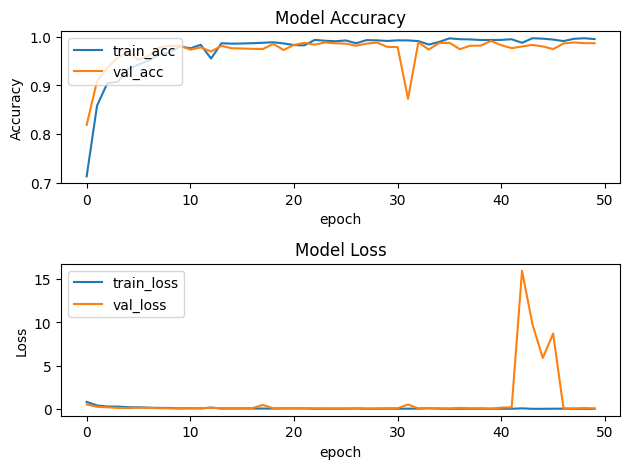

In [ ]:
# Evaluation and plotting the validation accuary and loss
#Eff_V2B2_final.save('Eff_V2B2.h5')
loss, accuracy = EffV2_model.evaluate(X_valid, y_valid)
print(f"Loss: {loss}, Accuracy: {np.round(accuracy*100,2)}%")
plot_accuracy_and_loss(EffV2_final_model)

#### **ViT 8x8 model**

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        num_patches = tf.shape(patches)[1] * tf.shape(patches)[2]
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dims])
        return patches

In [ ]:
def vit_classifier(num_classes, image_size=32, patch_size=8, projection_dim=64):
    inputs = layers.Input(shape=(image_size, image_size, 3))
    patches = Patches(patch_size)(inputs)
    encoded_patches = layers.Dense(projection_dim)(patches)

    # Transformer block
    for _ in range(4):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=projection_dim, dropout=0.1)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(units=projection_dim * 2, activation='relu')(x3)
        x3 = layers.Dense(units=projection_dim, activation='relu')(x3)
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.GlobalAveragePooling1D()(encoded_patches)
    x = layers.Dense(1024, activation='relu')(representation)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

vit8x8_model = vit_classifier(num_classes=7)
vit8x8_model.summary()

vit8x8_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 patches (Patches)           (None, 16, 192)              0         ['input_2[0][0]']             
                                                                                                  
 dense_2 (Dense)             (None, 16, 64)               12352     ['patches[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, 16, 64)               128       ['dense_2[0][0]']             
 Normalization)                                                                             

In [ ]:
ViT8x8 = vit8x8_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32, callbacks = [reduce_LearningRate])

Epoch 1/50
1091/1091 [==============================] - 31s 19ms/step - loss: 4.3431 - accuracy: 0.3453 - val_loss: 2.2435 - val_accuracy: 0.3996 - lr: 0.0010
Epoch 2/50
1091/1091 [==============================] - 19s 18ms/step - loss: 1.4870 - accuracy: 0.5141 - val_loss: 0.9235 - val_accuracy: 0.6617 - lr: 0.0010
Epoch 3/50
1091/1091 [==============================] - 19s 18ms/step - loss: 1.1965 - accuracy: 0.5908 - val_loss: 0.8179 - val_accuracy: 0.6868 - lr: 0.0010
Epoch 4/50
1091/1091 [==============================] - 20s 18ms/step - loss: 0.9433 - accuracy: 0.6564 - val_loss: 0.9305 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 5/50
1091/1091 [==============================] - 19s 18ms/step - loss: 0.8172 - accuracy: 0.6944 - val_loss: 0.8367 - val_accuracy: 0.6674 - lr: 0.0010
Epoch 6/50
1091/1091 [==============================] - 20s 18ms/step - loss: 0.7243 - accuracy: 0.7230 - val_loss: 0.7219 - val_accuracy: 0.7264 - lr: 0.0010
Epoch 7/50
1091/1091 [========================

182/182 [==============================] - 1s 6ms/step - loss: 0.2133 - accuracy: 0.9165
Loss: 0.2133183777332306, Accuracy: 91.65


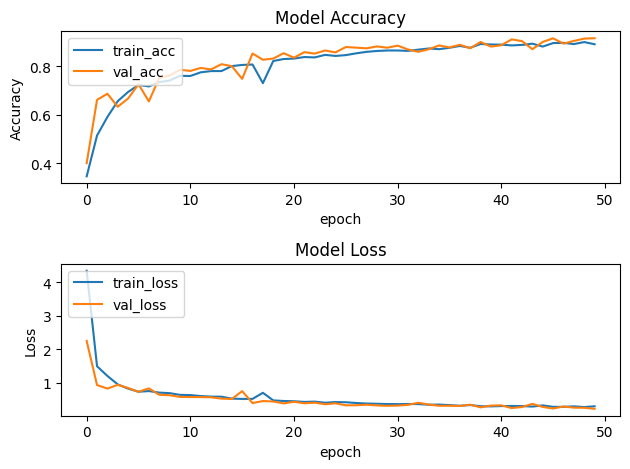

In [ ]:
# Evaluation and plotting the validation accuary and loss
#vit8x8_model.save('vit8x8.h5')
loss1, accuracy1 = vit8x8_model.evaluate(X_valid, y_valid)
print(f"Loss: {loss1}, Accuracy: {np.round(accuracy1*100,2)}")
plot_accuracy_and_loss(ViT8x8)

#### **Swin Transformer**

In [ ]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    x = tf.reshape(x, [-1, height // window_size, window_size, width // window_size, window_size, channels])
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, [-1, window_size, window_size, channels])
    return windows

def window_reverse(windows, window_size, height, width):
    _, channels = windows.shape[-2:]
    x = tf.reshape(windows, [-1, height // window_size, width // window_size, window_size, window_size, channels])
    x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, [-1, height, width, channels])
    return x

class SwinTransformerBlock(layers.Layer):
    def __init__(self, dim, num_heads, window_size=7, shift_size=0):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.mlp_block = tf.keras.Sequential([
            layers.Dense(dim * 4, activation='gelu'),
            layers.Dense(dim)
        ])
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

    def call(self, x):
        height, width = x.shape[1], x.shape[2]

        if self.shift_size > 0:
            x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])

        x_windows = window_partition(x, self.window_size)
        x_windows = self.norm1(x_windows)
        attn_windows = self.attn(x_windows, x_windows) + x_windows
        attn_windows = self.mlp_block(self.norm2(attn_windows)) + attn_windows

        x = window_reverse(attn_windows, self.window_size, height, width)

        if self.shift_size > 0:
            x = tf.roll(x, shift=[self.shift_size, self.shift_size], axis=[1, 2])

        return x



In [ ]:
def Swin_Transformer(input_shape=(32, 32, 3), num_classes=7):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(96, kernel_size=(4, 4), strides=(4, 4), padding="same")(inputs)
    x = SwinTransformerBlock(dim=96, num_heads=3, window_size=4, shift_size=2)(x)
    x = SwinTransformerBlock(dim=96, num_heads=3, window_size=4, shift_size=0)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

SwinT_model = Swin_Transformer()
SwinT_model.summary()

SwinT_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 96)          4704      
                                                                 
 swin_transformer_block (Sw  (None, 8, 8, 96)          186144    
 inTransformerBlock)                                             
                                                                 
 swin_transformer_block_1 (  (None, 8, 8, 96)          186144    
 SwinTransformerBlock)                                           
                                                                 
 global_average_pooling2d_1  (None, 96)                0         
  (GlobalAveragePooling2D)                                       
                                                           

In [ ]:
SwinT = SwinT_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=32, callbacks = [reduce_LearningRate])

Epoch 1/50
1091/1091 [==============================] - 20s 12ms/step - loss: 1.4387 - accuracy: 0.4282 - val_loss: 1.2210 - val_accuracy: 0.5153 - lr: 0.0010
Epoch 2/50
1091/1091 [==============================] - 12s 11ms/step - loss: 1.1393 - accuracy: 0.5532 - val_loss: 1.0664 - val_accuracy: 0.5937 - lr: 0.0010
Epoch 3/50
1091/1091 [==============================] - 12s 11ms/step - loss: 0.9647 - accuracy: 0.6280 - val_loss: 0.8884 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 4/50
1091/1091 [==============================] - 12s 11ms/step - loss: 0.8270 - accuracy: 0.6805 - val_loss: 0.7182 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 5/50
1091/1091 [==============================] - 13s 12ms/step - loss: 0.7021 - accuracy: 0.7328 - val_loss: 0.6258 - val_accuracy: 0.7558 - lr: 0.0010
Epoch 6/50
1091/1091 [==============================] - 12s 11ms/step - loss: 0.5864 - accuracy: 0.7769 - val_loss: 0.6409 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 7/50
1091/1091 [========================

182/182 [==============================] - 1s 4ms/step - loss: 0.2161 - accuracy: 0.9414
Loss: 0.21610483527183533, Accuracy: 94.14


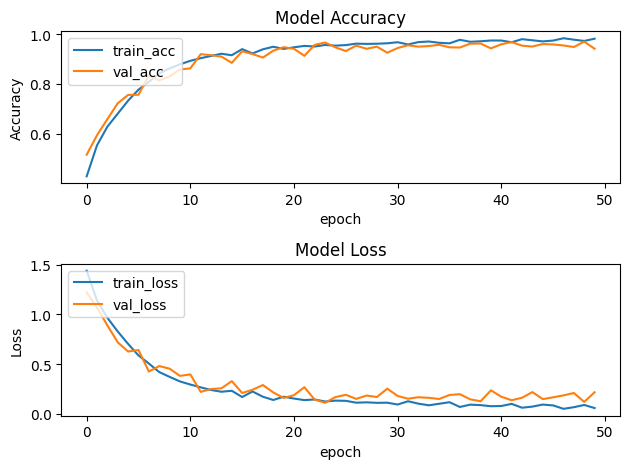

In [ ]:
# Evaluation and plotting the validation accuary and loss
#SwinT_model.save('SwinT.h5')
loss2, accuracy2 = SwinT_model.evaluate(X_valid, y_valid)
print(f"Loss: {loss2}, Accuracy: {np.round(accuracy2*100,2)}")
plot_accuracy_and_loss(SwinT)

# Model Testing and Evaluation

### **Testing phase - 1:** Model testing using hold-out test image set

In [ ]:
target_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

182/182 [==============================] - 2s 10ms/step
Accuracy Score: 98.5%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       841
           1       0.99      1.00      1.00       864
           2       0.94      1.00      0.97       795
           3       1.00      1.00      1.00       822
           4       0.97      0.99      0.98       821
           5       0.99      0.91      0.95       840
           6       1.00      1.00      1.00       835

    accuracy                           0.99      5818
   macro avg       0.99      0.99      0.98      5818
weighted avg       0.99      0.99      0.98      5818



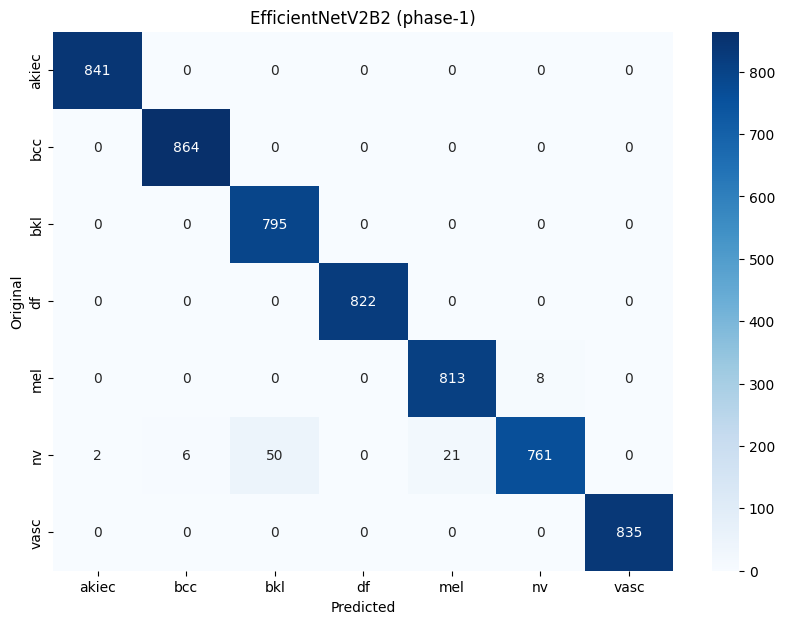

In [ ]:
# EfficientNetV2B2

y_pred = EffV2_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("Accuracy Score: {}%".format(np.round(accuracy_score(y_test,y_pred)*100, 2)))
print(classification_report(y_test,y_pred))
cm_effv2 = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_effv2, annot=True, fmt="d", cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Original')
plt.title('EfficientNetV2B2 (phase-1)')
plt.show()


182/182 [==============================] - 1s 6ms/step
Accuracy Score: 91.27%
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       841
           1       0.98      0.97      0.97       864
           2       0.83      0.87      0.85       795
           3       1.00      1.00      1.00       822
           4       0.82      0.83      0.82       821
           5       0.78      0.74      0.76       840
           6       0.99      1.00      1.00       835

    accuracy                           0.91      5818
   macro avg       0.91      0.91      0.91      5818
weighted avg       0.91      0.91      0.91      5818



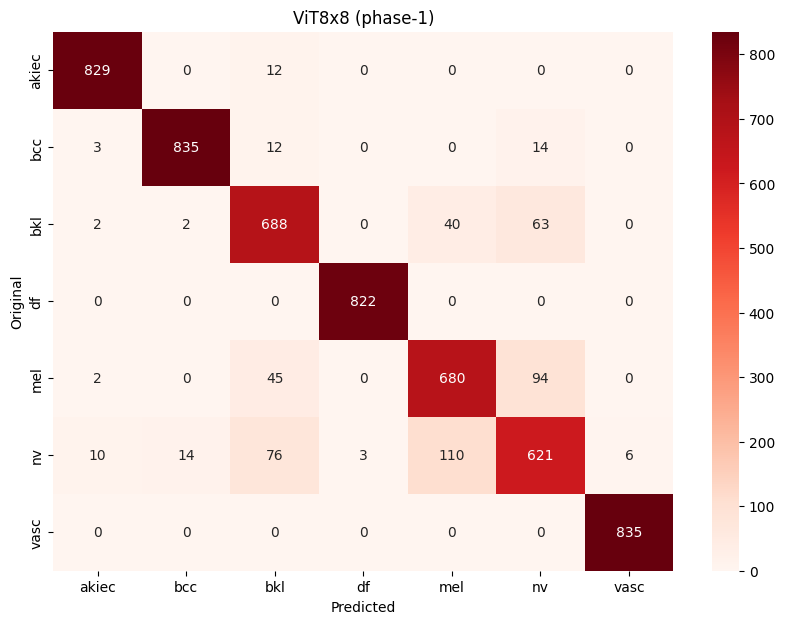

In [ ]:
# ViT 8x8

y_pred1 = vit8x8_model.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis=1)
print("Accuracy Score: {}%".format(np.round(accuracy_score(y_test,y_pred1)*100, 2)))
print(classification_report(y_test,y_pred1))
cm_vit = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_vit, annot=True, fmt="d", cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Original')
plt.title('ViT8x8 (phase-1)')
plt.show()

182/182 [==============================] - 1s 4ms/step
Accuracy Score: 94.64%
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       841
           1       0.96      0.96      0.96       864
           2       0.95      0.88      0.91       795
           3       0.99      1.00      0.99       822
           4       0.86      0.98      0.92       821
           5       0.89      0.83      0.86       840
           6       0.99      0.99      0.99       835

    accuracy                           0.95      5818
   macro avg       0.95      0.95      0.95      5818
weighted avg       0.95      0.95      0.95      5818



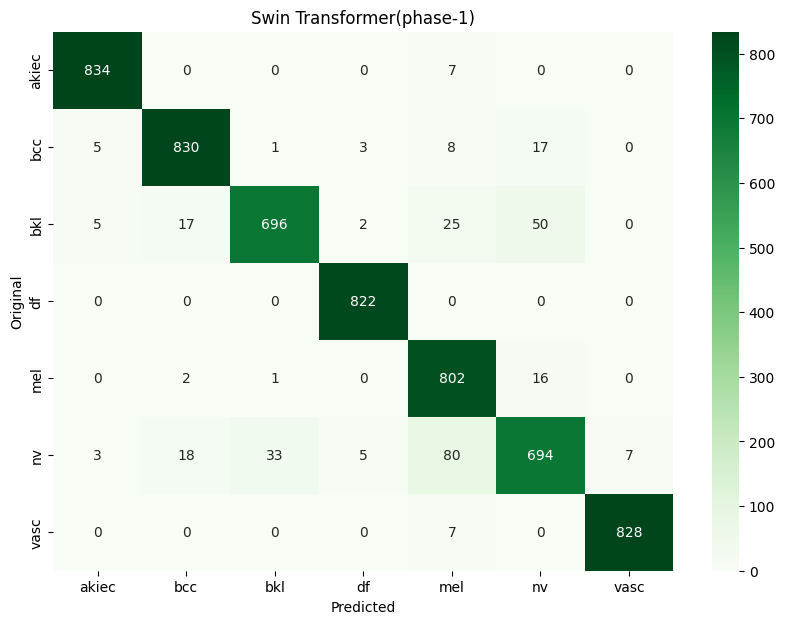

In [ ]:
#Swin Transformer

y_pred2 = SwinT_model.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis=1)

print("Accuracy Score: {}%".format(np.round(accuracy_score(y_test,y_pred2)*100, 2)))
print(classification_report(y_test,y_pred2))
cm_swin = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_swin, annot=True, fmt="d", cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Original')
plt.title('Swin Transformer(phase-1)')
plt.show()

### **Testing phase - 2:** Model testing on external image set (ISIC2018_Task3_Test_Images)

In [ ]:
test_data = pd.read_csv("/content/dataverse_files/ISIC2018_Task3_Test_GroundTruth.csv")

test_df = test_data
directory = '/content/dataverse_files/ISIC2018_Task3_Test_Images'
id_column = 'image_id'
path_column = 'image_path'

for index, row in test_df.iterrows():
    image_id = row[id_column]
    image_path = get_image_path(image_id, directory)
    test_df.at[index, path_column] = image_path

test_df.dropna(inplace=True)
print("Shape of the test image set: {}".format(test_df.shape))
test_df.head(2)

Shape of the test image set: (1230, 9)


lesion_id      image_id  dx    dx_type   age     sex localization  \
0  HAMTEST_0000000  ISIC_0034524  nv  follow_up  40.0  female         back   
1  HAMTEST_0000001  ISIC_0034525  nv      histo  70.0    male      abdomen   

         dataset                                         image_path  
0  vidir_molemax  /content/dataverse_files/ISIC2018_Task3_Test_I...  
1      rosendahl  /content/dataverse_files/ISIC2018_Task3_Test_I...

In [ ]:
test_df['label'] = LabelEncoder().fit_transform(test_df['dx'])

print("Label Encoding:")
for original_label, encoded_label in zip(test_df['dx'].unique(), test_df['label'].unique()):
    print(f"{original_label} -> {encoded_label}")

test_df['image'] = test_df['image_path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

X = test_df['image'].to_numpy()
X = np.stack(X, axis=0)
y = np.array(test_df.label)
print(X.shape)
print(y.shape)

Label Encoding:
nv -> 5
bkl -> 2
akiec -> 0
bcc -> 1
mel -> 4
vasc -> 6
df -> 3
(1230, 32, 32, 3)
(1230,)


39/39 [==============================] - 1s 14ms/step
Accuracy Score: 70.41%
              precision    recall  f1-score   support

           0       0.21      0.15      0.18        40
           1       0.42      0.44      0.43        64
           2       0.39      0.53      0.45       141
           3       0.56      0.28      0.37        18
           4       0.49      0.36      0.42       152
           5       0.85      0.87      0.86       796
           6       0.89      0.42      0.57        19

    accuracy                           0.70      1230
   macro avg       0.54      0.44      0.47      1230
weighted avg       0.70      0.70      0.70      1230



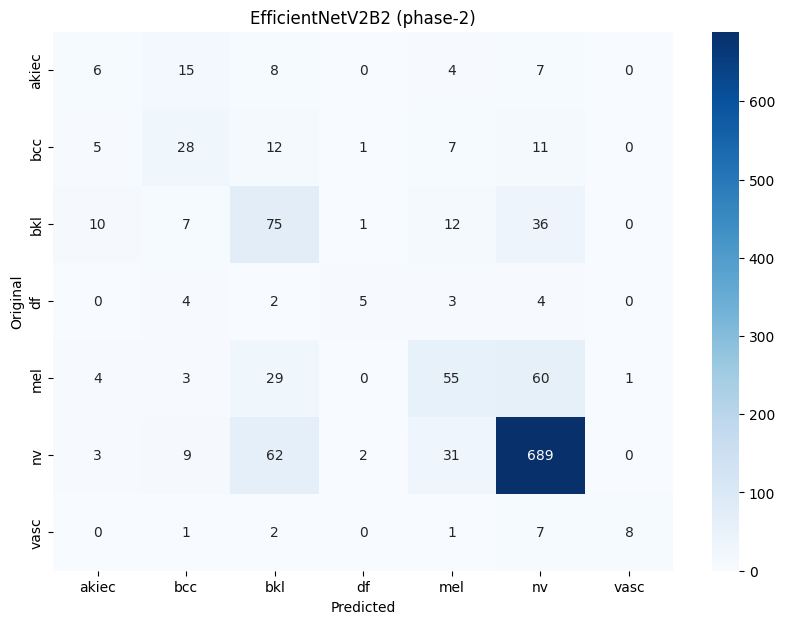

In [ ]:
# EfficientNetV2B2

y_pred = EffV2_model.predict(X)
y_pred = tf.argmax(y_pred, axis=1)

print("Accuracy Score: {}%".format(np.round(accuracy_score(y,y_pred)*100, 2)))
print(classification_report(y, y_pred))
cm_effv2 = confusion_matrix(y, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_effv2, annot=True, fmt="d", cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Original')
plt.title('EfficientNetV2B2 (phase-2)')
plt.show()


39/39 [==============================] - 0s 6ms/step
Accuracy Score: 63.5%
              precision    recall  f1-score   support

           0       0.26      0.23      0.24        40
           1       0.38      0.34      0.36        64
           2       0.31      0.48      0.38       141
           3       0.00      0.00      0.00        18
           4       0.34      0.53      0.41       152
           5       0.89      0.75      0.81       796
           6       0.57      0.42      0.48        19

    accuracy                           0.63      1230
   macro avg       0.39      0.39      0.38      1230
weighted avg       0.69      0.63      0.65      1230



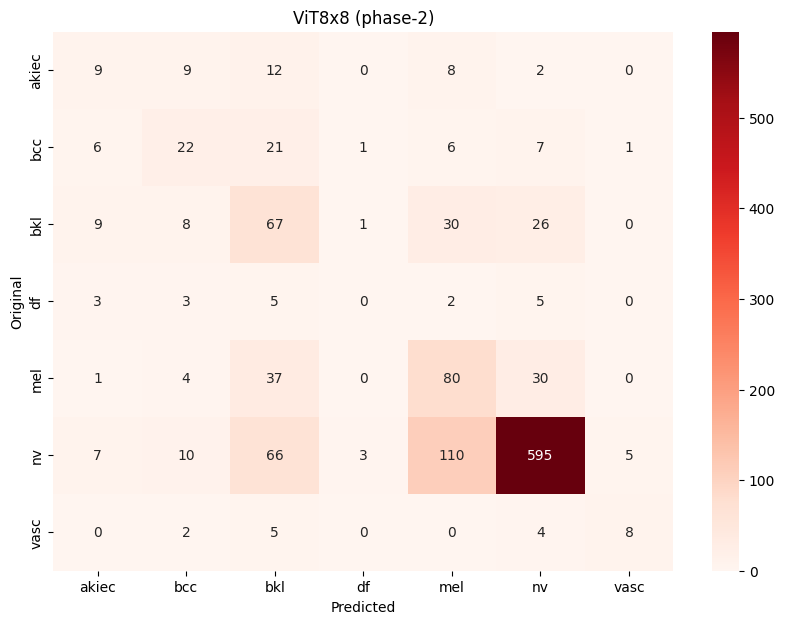

In [ ]:
# ViT 8x8

y_pred1 = vit8x8_model.predict(X)
y_pred1 = tf.argmax(y_pred1, axis=1)

print("Accuracy Score: {}%".format(np.round(accuracy_score(y,y_pred1)*100, 2)))
print(classification_report(y, y_pred1))
cm_vit = confusion_matrix(y, y_pred1)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_vit, annot=True, fmt="d", cmap='Reds', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Original')
plt.title('ViT8x8 (phase-2)')
plt.show()

39/39 [==============================] - 0s 4ms/step
Accuracy Score: 65.04%
              precision    recall  f1-score   support

           0       0.31      0.28      0.29        40
           1       0.26      0.23      0.25        64
           2       0.38      0.34      0.36       141
           3       0.07      0.06      0.06        18
           4       0.33      0.51      0.40       152
           5       0.86      0.80      0.83       796
           6       0.47      0.37      0.41        19

    accuracy                           0.65      1230
   macro avg       0.38      0.37      0.37      1230
weighted avg       0.67      0.65      0.66      1230



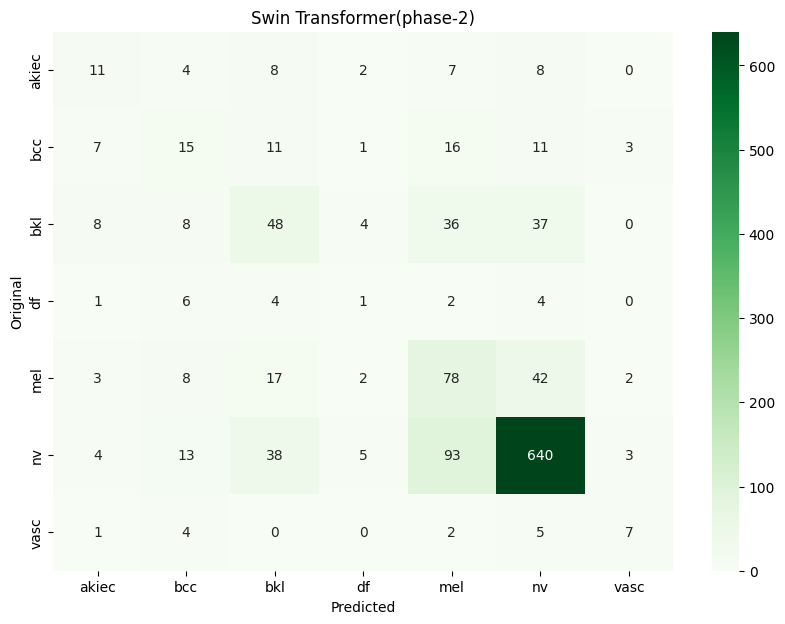

In [ ]:
#Swin Transformer

y_pred2 = SwinT_model.predict(X)
y_pred2 = tf.argmax(y_pred2, axis=1)

print("Accuracy Score: {}%".format(np.round(accuracy_score(y,y_pred2)*100, 2)))
print(classification_report(y, y_pred2))
cm_swin = confusion_matrix(y, y_pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_swin, annot=True, fmt="d", cmap='Greens', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Original')
plt.title('Swin Transformer(phase-2)')
plt.show()